# Quadcopter Trajectory Optimization

Let's take a look at an idealized 2D quadcopter that consists of a vehicle in 2D with two propellers (a left one and a right one). To illustrate this, let's build up some data structures.

## Data Structures (feel free to skip, only for visualization)

First, we'll make a `QuadcopterDynamics` class by subclassing the `FreeBodyDynamics` class. (Basically, we're making a copy here that we can tack on various methods to).

We'll add a `draw()` method here that will let us visualize what's happening.

In [309]:
import aerosandbox as asb
import aerosandbox.numpy as np
from aerosandbox.dynamics.dynamics import FreeBodyDynamics
from aerosandbox.tools.pretty_plots import plt, show_plot, mpl, adjust_lightness


class QuadcopterDynamics(FreeBodyDynamics):
    @staticmethod
    def draw_vehicle(xe, ze, theta,
                     color="#bc5eff",
                     left_color=None,
                     right_color=None,
                     vehicle_magnify=1
                     ):
        ### Draw the vehicle, normalized to have the total width be 1.
        height = 0.05
        prop_width = 0.65
        prop_AR = 0.2
        bodycolor = adjust_lightness(color, 0.2)
        left_prop_color = color if left_color is None else left_color
        right_prop_color = color if right_color is None else right_color

        vehicle_patches = mpl.collections.PatchCollection(
            [
                mpl.patches.Rectangle(  # Body
                    xy=(-0.5, -height / 2),
                    width=1, height=height,
                    color=bodycolor
                ),
                mpl.patches.Ellipse(  # Hub
                    xy=(0, height / 2),
                    width=0.3, height=0.1,
                    color=bodycolor
                ),
                mpl.patches.PathPatch(  # Legs
                    mpl.path.Path(
                        np.array([
                            [-0.2, -0.15],
                            [-0.1, 0],
                            [0.1, 0],
                            [0.2, -0.15],
                            [0.18, -0.15],
                            [0.05, 0],
                            [-0.05, 0],
                            [-0.18, -0.15],

                        ]),
                    ),
                    color=bodycolor
                ),
                mpl.patches.Ellipse(  # Left propeller
                    xy=(-0.5, height / 2 + 0.03),
                    width=prop_width, height=prop_width * prop_AR,
                    color=left_prop_color,
                    alpha=0.5
                ),
                mpl.patches.Ellipse(  # Right propeller
                    xy=(0.5, height / 2 + 0.03),
                    width=prop_width, height=prop_width * prop_AR,
                    color=right_prop_color,
                    alpha=0.5
                )
            ],
            match_original=True
        )

        t = mpl.transforms.Affine2D()
        t.scale(0.1)  # set the right size
        t.scale(vehicle_magnify)
        t.rotate(theta - np.pi / 2)  # rotate to orient theta the right way
        t.translate(xe, -ze)  # Move the quad to where it needs to be
        vehicle_patches.set_transform(t + plt.gca().transData)

        vehicle_patches.set_zorder(5)

        plt.gca().add_collection(vehicle_patches)

    def draw(self,
             show=True,
             left_thrust=None,
             right_thrust=None,
             vehicle_magnify=1,
             draw_interval=1,
             ):

        def make_iterable(var):
            try:
                iter(var)
                return var
            except TypeError:
                return [var] * np.length(self.time)

        if left_thrust is None or right_thrust is None:
            for xe, ze, theta in zip(
                    make_iterable(self.xe)[::draw_interval],
                    make_iterable(self.ze)[::draw_interval],
                    make_iterable(self.theta)[::draw_interval]
            ):
                self.draw_vehicle(
                    xe=xe,
                    ze=ze,
                    theta=theta,
                    vehicle_magnify=vehicle_magnify,
                )
        else:
            for xe, ze, theta, left, right in zip(
                    make_iterable(self.xe)[::draw_interval],
                    make_iterable(self.ze)[::draw_interval],
                    make_iterable(self.theta)[::draw_interval],
                    make_iterable(left_thrust)[::draw_interval],
                    make_iterable(right_thrust)[::draw_interval],
            ):
                cmap = mpl.cm.get_cmap('turbo') # coolwarm_r
                thrusts = np.array((left_thrust, right_thrust))
                norm = mpl.colors.Normalize(
                    vmin=-0.1, #thrusts.min(),
                    vmax=1.1, #thrusts.max()
                )
                self.draw_vehicle(
                    xe=xe,
                    ze=ze,
                    theta=theta,
                    vehicle_magnify=vehicle_magnify,
                    color="k",
                    left_color=cmap(norm(left)),
                    right_color=cmap(norm(right))
                )
            plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label="Thrust [N]")

        plt.plot(
            make_iterable(self.xe),
            make_iterable(-self.ze),
            zorder=2
        )

        if vehicle_magnify != 1:
            plt.annotate(
                text=f"Vehicle displayed {vehicle_magnify}x larger for visibility.",
                xy=(0.02, 0.02),
                xycoords="axes fraction",
                ha="left",
                fontsize=9
            )

        plt.axis("equal")
        show_plot(
            "Quadcopter",
            r"$x_e$ [m]",
            r"$-z_e$ [m]",
            show=show
        )

Here's our quadcopter!

C:\GitHub\AeroSandbox\aerosandbox\dynamics\dynamics.py:77: UserWarning: Can't add physics constraints to your dynamics environment, since no `opti` instance was provided. Skipping...
  warnings.warn(


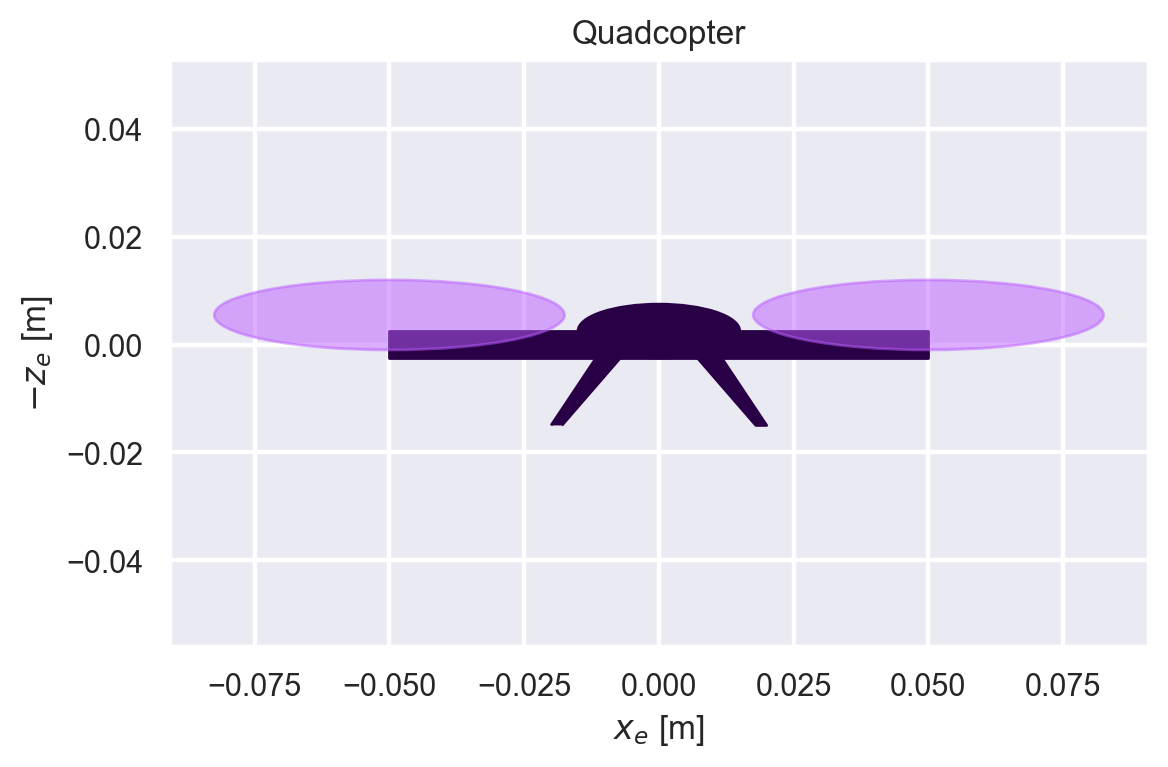

In [310]:
dyn = QuadcopterDynamics(
    time=0,
    theta=np.radians(90),
    ze=0
)

dyn.draw()

## Dynamics

Now, let's set up some dynamics here. How about we simulate what happens when we have a slightly asymmetric thrust input?

Here, we'll color the propellers by their instantaneous thrust output - blue is high thrust, and red is low thrust.

C:\ProgramData\Anaconda3\lib\site-packages\casadi\casadi.py:10909: RuntimeWarning: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.
  warnings.warn("Implicit conversion of symbolic CasADi type to numeric matrix not supported.\n"


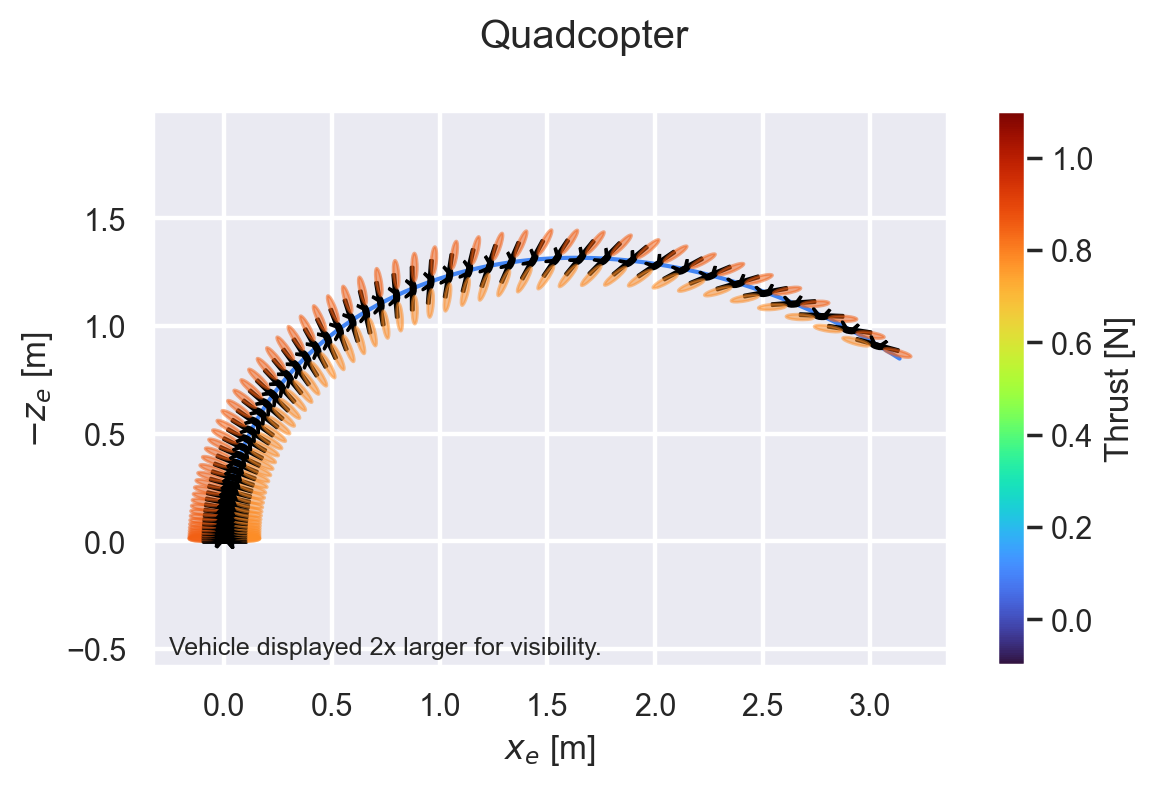

In [311]:
opti = asb.Opti()

mass = 0.1

N = 300
time = np.linspace(0, 1, N)

left_thrust = 0.85
right_thrust = 0.78

dyn = QuadcopterDynamics(
    opti=opti,
    time=time,
    xe=opti.variable(init_guess=0, n_vars=N),
    ze=opti.variable(init_guess=0, n_vars=N),
    u=opti.variable(init_guess=0, n_vars=N),
    w=opti.variable(init_guess=0, n_vars=N),
    theta=opti.variable(init_guess=0, n_vars=N),
    q=opti.variable(init_guess=0, n_vars=N),
    X=left_thrust + right_thrust,
    M=(right_thrust - left_thrust) * 0.1 / 2,
    mass=mass,
    Iyy=0.5 * mass * 0.1 ** 2,
    g=9.81,
)

opti.subject_to([
    dyn.xe[0] == 0,
    dyn.ze[0] == 0,
    dyn.u[0] == 0,
    dyn.w[0] == 0,
    dyn.theta[0] == np.radians(90),
    dyn.q[0] == 0,
])

sol = opti.solve(verbose=False)
dyn.substitute_solution(sol)
dyn.draw(draw_interval=5, vehicle_magnify=2, left_thrust=left_thrust, right_thrust=right_thrust)

Yep, reminds me of the first time that I tried to fly a quad!

How about something more sophisticated. Let's do a flip!

## Quadcopter Flip Optimal Control Problem

Let's do a flip, starting at the origin and stopping to the side of us, in the minimum time possible. We'll bound our thrust inputs to a reasonable range and see what we can do!

C:\ProgramData\Anaconda3\lib\site-packages\casadi\casadi.py:10909: RuntimeWarning: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.
  warnings.warn("Implicit conversion of symbolic CasADi type to numeric matrix not supported.\n"


Flip maneuver completed in 0.824 sec.


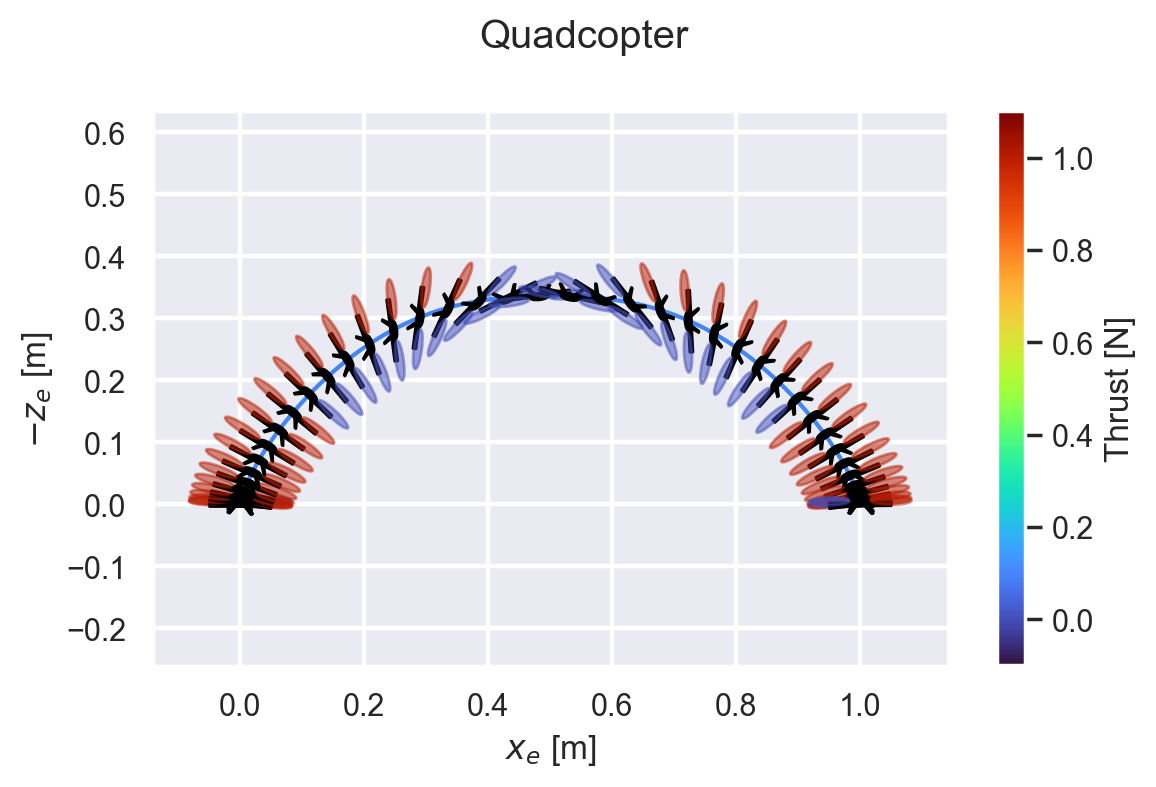

In [312]:
opti = asb.Opti()

N = 300
time_final = opti.variable(init_guess=1, lower_bound=0)
time = np.linspace(0, time_final, N)

left_thrust = opti.variable(init_guess=0.7, scale=1, n_vars=N, lower_bound=0, upper_bound=1)
right_thrust = opti.variable(init_guess=0.6, scale=1, n_vars=N, lower_bound=0, upper_bound=1)

mass = 0.1

dyn = QuadcopterDynamics(
    opti=opti,
    time=time,
    xe=opti.variable(init_guess=np.linspace(0, 1, N)),
    ze=opti.variable(init_guess=0, n_vars=N),
    u=opti.variable(init_guess=0, n_vars=N),
    w=opti.variable(init_guess=0, n_vars=N),
    theta=opti.variable(init_guess=np.linspace(np.pi / 2, np.pi / 2 - 2 * np.pi, N)),
    q=opti.variable(init_guess=0, n_vars=N),
    X=left_thrust + right_thrust,
    M=(right_thrust - left_thrust) * 0.1 / 2,
    mass=mass,
    Iyy=0.5 * mass * 0.1 ** 2,
    g=9.81,
)

opti.subject_to([  # Starting state
    dyn.xe[0] == 0,
    dyn.ze[0] == 0,
    dyn.u[0] == 0,
    dyn.w[0] == 0,
    dyn.theta[0] == np.radians(90),
    dyn.q[0] == 0,
])

opti.subject_to([  # Final state
    dyn.xe[-1] == 1,
    dyn.ze[-1] == 0,
    dyn.u[-1] == 0,
    dyn.w[-1] == 0,
    dyn.theta[-1] == np.radians(90 - 360),
    dyn.q[-1] == 0,
])

opti.minimize(time_final)

sol = opti.solve(verbose=False)
dyn.substitute_solution(sol)
dyn.draw(
    draw_interval=7,
    left_thrust=sol.value(left_thrust),
    right_thrust=sol.value(right_thrust)
)
print(f"Flip maneuver completed in {sol.value(time_final):.3} sec.")

How about a backflip?

C:\ProgramData\Anaconda3\lib\site-packages\casadi\casadi.py:10909: RuntimeWarning: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.
  warnings.warn("Implicit conversion of symbolic CasADi type to numeric matrix not supported.\n"


Flip maneuver completed in 1.0 sec.


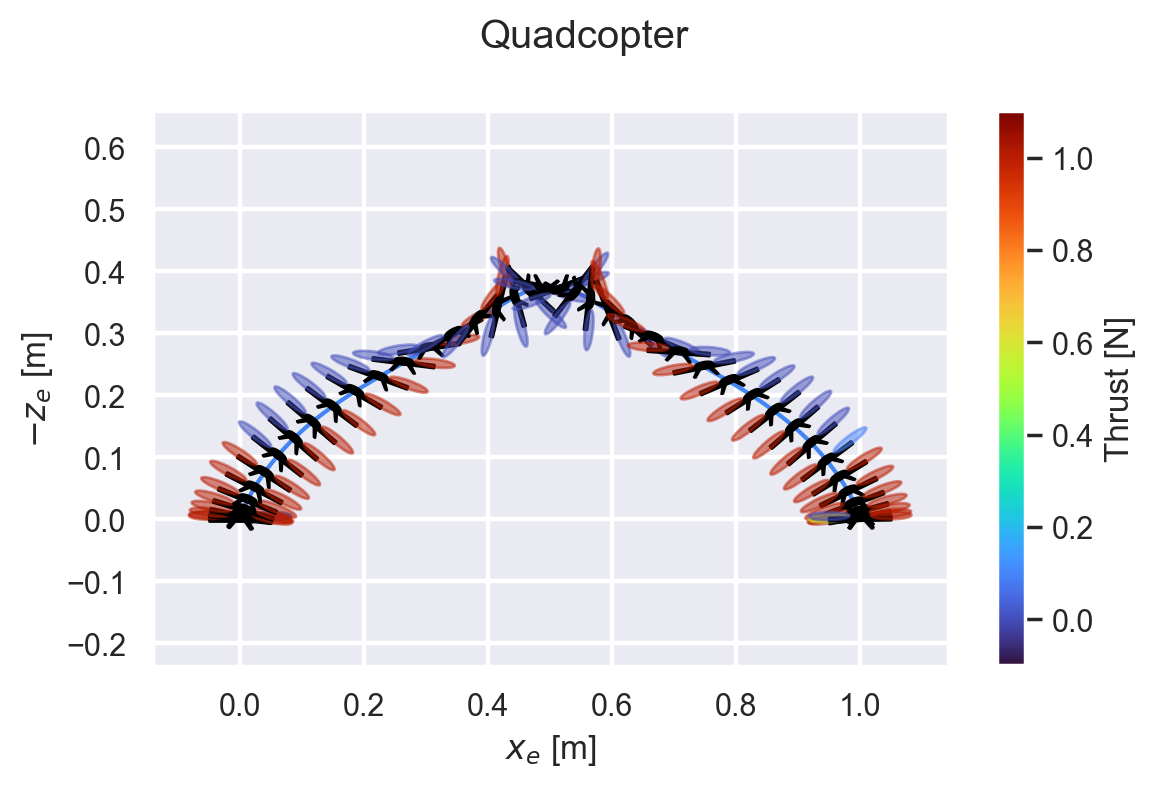

In [313]:
opti = asb.Opti()

N = 300
time_final = opti.variable(init_guess=1, lower_bound=0)
time = np.linspace(0, time_final, N)

left_thrust = opti.variable(init_guess=0.7, scale=1, n_vars=N, lower_bound=0, upper_bound=1)
right_thrust = opti.variable(init_guess=0.6, scale=1, n_vars=N, lower_bound=0, upper_bound=1)

mass = 0.1

dyn = QuadcopterDynamics(
    opti=opti,
    time=time,
    xe=opti.variable(init_guess=np.linspace(0, 1, N)),
    ze=opti.variable(init_guess=0, n_vars=N),
    u=opti.variable(init_guess=0, n_vars=N),
    w=opti.variable(init_guess=0, n_vars=N),
    theta=opti.variable(init_guess=np.linspace(np.pi / 2, np.pi / 2 + 2 * np.pi, N)),
    q=opti.variable(init_guess=0, n_vars=N),
    X=left_thrust + right_thrust,
    M=(right_thrust - left_thrust) * 0.1 / 2,
    mass=mass,
    Iyy=0.5 * mass * 0.1 ** 2,
    g=9.81,
)

opti.subject_to([  # Starting state
    dyn.xe[0] == 0,
    dyn.ze[0] == 0,
    dyn.u[0] == 0,
    dyn.w[0] == 0,
    dyn.theta[0] == np.radians(90),
    dyn.q[0] == 0,
])

opti.subject_to([  # Final state
    dyn.xe[-1] == 1,
    dyn.ze[-1] == 0,
    dyn.u[-1] == 0,
    dyn.w[-1] == 0,
    dyn.theta[-1] == np.radians(90 + 360),
    dyn.q[-1] == 0,
])

opti.minimize(time_final)

sol = opti.solve(verbose=False)
dyn.substitute_solution(sol)
dyn.draw(
    draw_interval=7,
    left_thrust=sol.value(left_thrust),
    right_thrust=sol.value(right_thrust)
)
print(f"Flip maneuver completed in {sol.value(time_final):.3} sec.")

How about something more tame, like navigating from point A to B in a given time while minimizing an "effort" metric:

C:\ProgramData\Anaconda3\lib\site-packages\casadi\casadi.py:10909: RuntimeWarning: Implicit conversion of symbolic CasADi type to numeric matrix not supported.
This may occur when you pass a CasADi object to a numpy function.
Use an equivalent CasADi function instead of that numpy function.
  warnings.warn("Implicit conversion of symbolic CasADi type to numeric matrix not supported.\n"


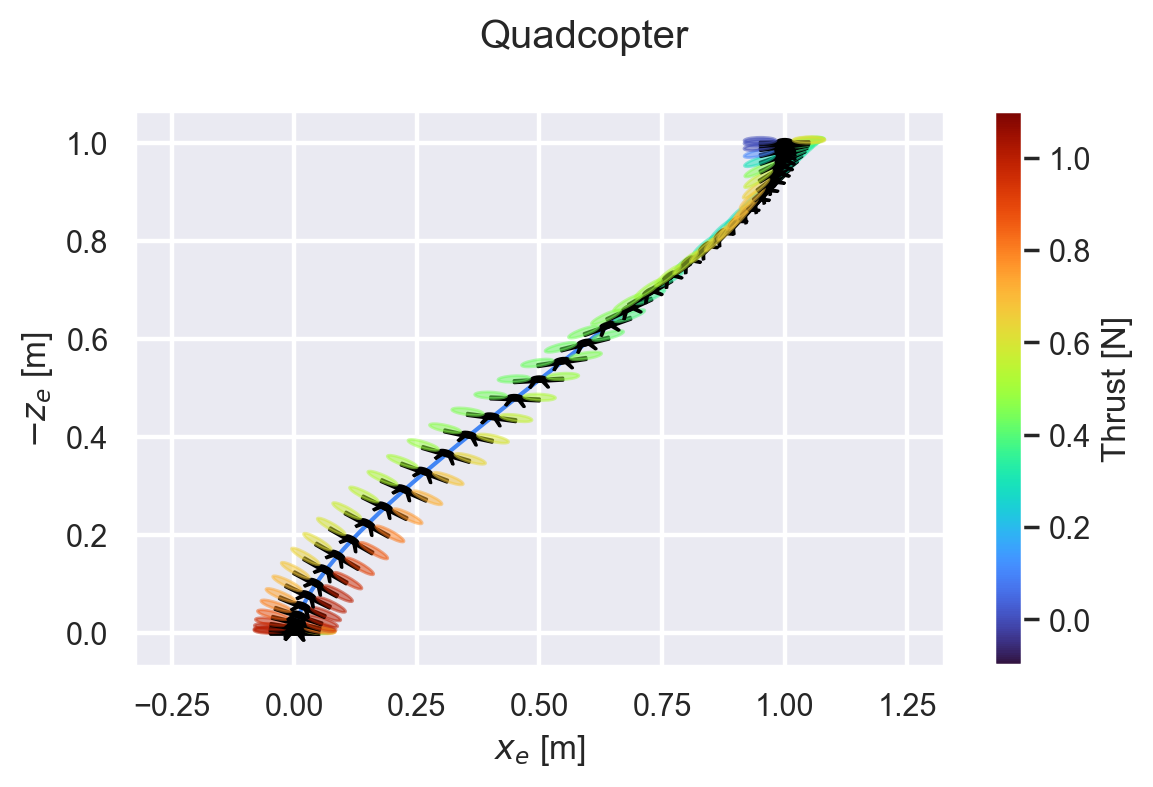

In [314]:
opti = asb.Opti()

N = 300
time_final = 1
time = np.linspace(0, time_final, N)

left_thrust = opti.variable(init_guess=0.5, scale=1, n_vars=N, lower_bound=0, upper_bound=1)
right_thrust = opti.variable(init_guess=0.5, scale=1, n_vars=N, lower_bound=0, upper_bound=1)

mass = 0.1

dyn = QuadcopterDynamics(
    opti=opti,
    time=time,
    xe=opti.variable(init_guess=np.linspace(0, 1, N)),
    ze=opti.variable(init_guess=np.linspace(0, -1, N)),
    u=opti.variable(init_guess=0, n_vars=N),
    w=opti.variable(init_guess=0, n_vars=N),
    theta=opti.variable(init_guess=np.linspace(np.pi / 2, np.pi / 2, N)),
    q=opti.variable(init_guess=0, n_vars=N),
    X=left_thrust + right_thrust,
    M=(right_thrust - left_thrust) * 0.1 / 2,
    mass=mass,
    Iyy=0.5 * mass * 0.1 ** 2,
    g=9.81,
)

opti.subject_to([  # Starting state
    dyn.xe[0] == 0,
    dyn.ze[0] == 0,
    dyn.u[0] == 0,
    dyn.w[0] == 0,
    dyn.theta[0] == np.radians(90),
    dyn.q[0] == 0,
])

opti.subject_to([  # Final state
    dyn.xe[-1] == 1,
    dyn.ze[-1] == -1,
    dyn.u[-1] == 0,
    dyn.w[-1] == 0,
    dyn.theta[-1] == np.radians(90),
    dyn.q[-1] == 0,
])

opti.minimize(
    np.sum(
        np.trapz(left_thrust ** 2 + right_thrust ** 2) * np.diff(time)
    ) / time_final
)

sol = opti.solve(verbose=False)
dyn.substitute_solution(sol)
dyn.draw(
    draw_interval=7,
    left_thrust=sol.value(left_thrust),
    right_thrust=sol.value(right_thrust)
)

In summary, we show here that using AeroSandbox's dynamics engine, you can pose and solve optimal control problems of practical interest with fewer than 50 lines of code.